In [4]:
import glob
import numpy as np
import pandas as pd

def aggregate_csv_files(directory_path):
    all_files = glob.glob(f"{directory_path}/*.csv")
    df_list = []

    for file in all_files:
        df = pd.read_csv(file)
        df_list.append(df)

    # Concatenate all DataFrames
    combined_df = pd.concat(df_list, ignore_index=True)

    # Drop rows with NaN or infinite values
    combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    combined_df.dropna(inplace=True)

    # Select the necessary columns
    aggregated_df = combined_df[['date', '1wk_WIS', '1_week_roc', 
                                 'is_wis_above_avg', '1st_deriv_stencil', 
                                 'week_of_year', 'moving_avg_WIS', 
                                 'lagged_1wk_WIS']]

    return aggregated_df

directory_path = './hosp_roc'
aggregated_data = aggregate_csv_files(directory_path)
aggregated_data

,date,1wk_WIS,1_week_roc,is_wis_above_avg,1st_deriv_stencil,week_of_year,moving_avg_WIS,lagged_1wk_WIS
2,2023-10-28,19.51,0.320000,0,7.333333,43,13.273333,13.51
3,2023-11-04,6.51,0.181818,0,4.166667,44,13.176667,19.51
4,2023-11-11,45.84,0.205128,0,27.750000,45,23.953333,6.51
5,2023-11-18,11.54,0.851064,0,16.416667,46,21.296667,45.84
6,2023-11-25,37.36,-0.034483,0,25.750000,47,31.580000,11.54
...,...,...,...,...,...,...,...,...
1243,2024-03-02,7.56,-0.173077,0,-1.000000,9,4.150000,1.44
1244,2024-03-09,13.41,0.209302,0,14.166667,10,7.470000,7.56
1245,2024-03-16,2.61,0.230769,0,-1.750000,11,7.860000,13.41
1246,2024-03-23,2.18,-0.218750,0,-8.000000,12,6.066667,2.61


In [2]:
"""Prepare the data."""

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

df = aggregated_data
df.dropna(inplace=True)

features = ['1_week_roc', 
            '1st_deriv_stencil', 
            'week_of_year', 
            'moving_avg_WIS', 
            'lagged_1wk_WIS']
X = df[features]
y = df['is_wis_above_avg']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
"""Train and evaluate the RF model."""

from sklearn.ensemble import RandomForestClassifier

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       155
           1       0.75      0.67      0.71        69

    accuracy                           0.83       224
   macro avg       0.81      0.78      0.79       224
weighted avg       0.83      0.83      0.83       224



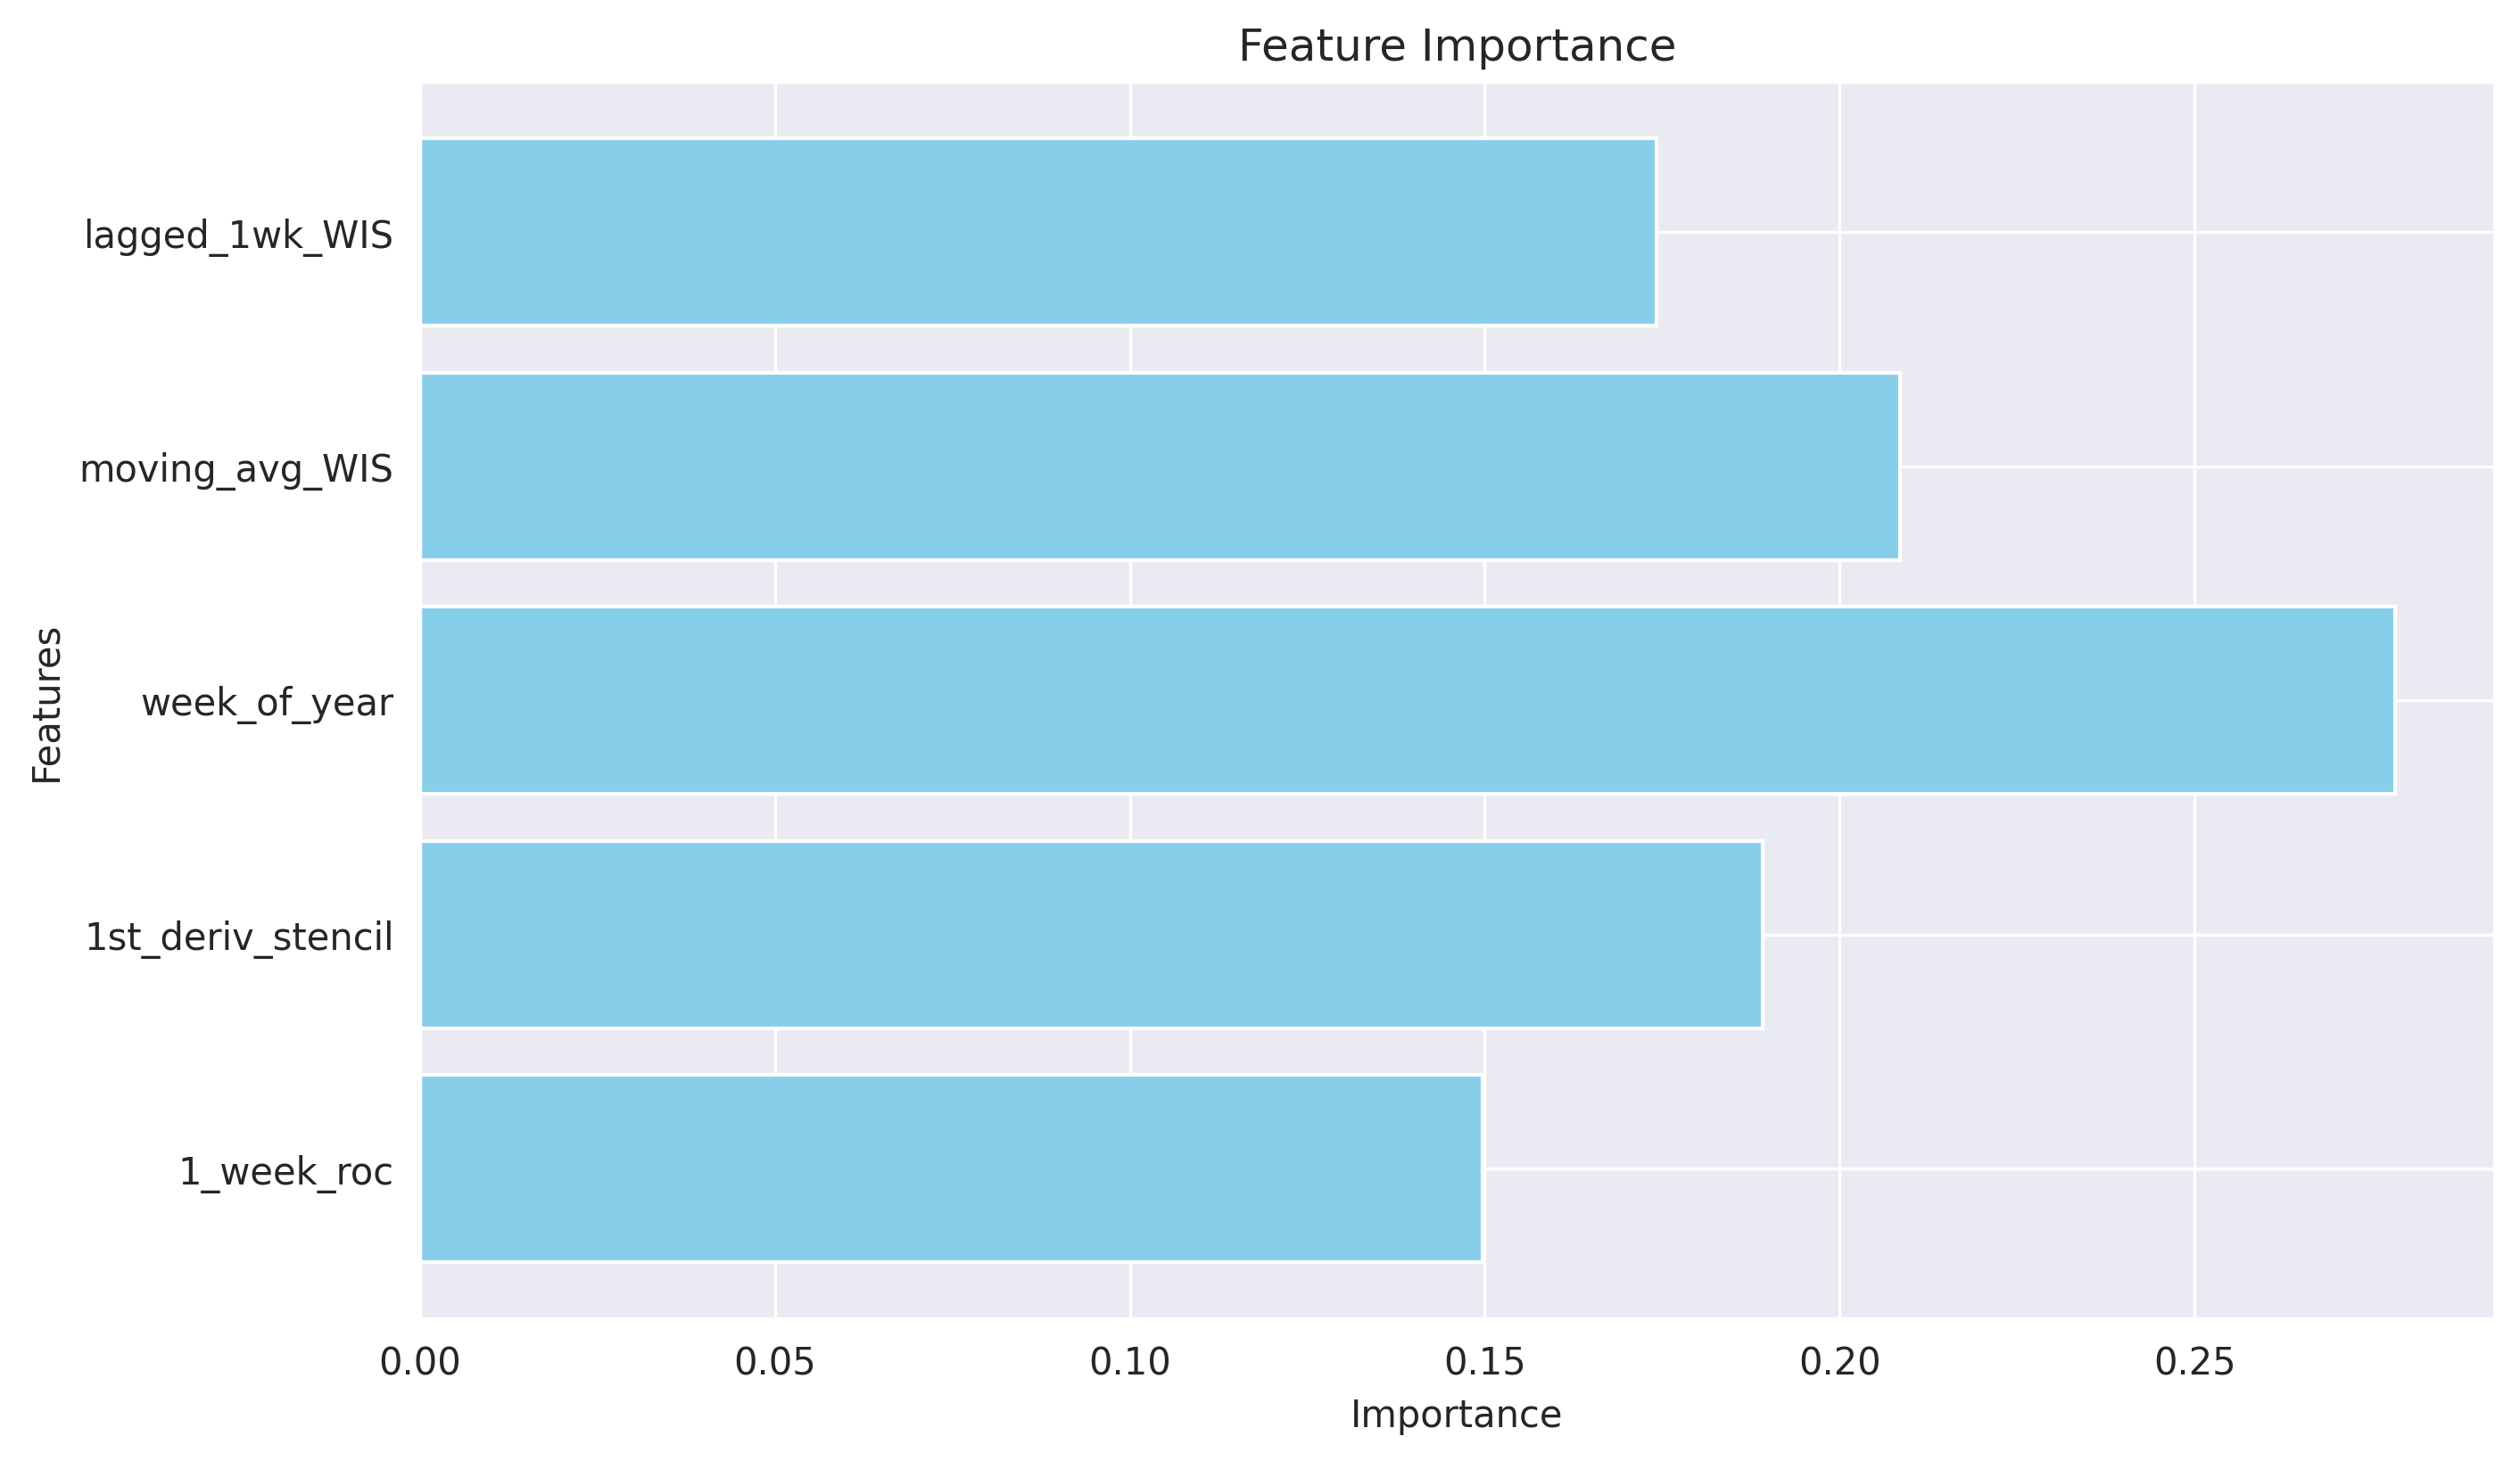

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Feature Importances
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Plot Feature Importances
plt.figure(figsize=(10, 6), dpi=300)
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()


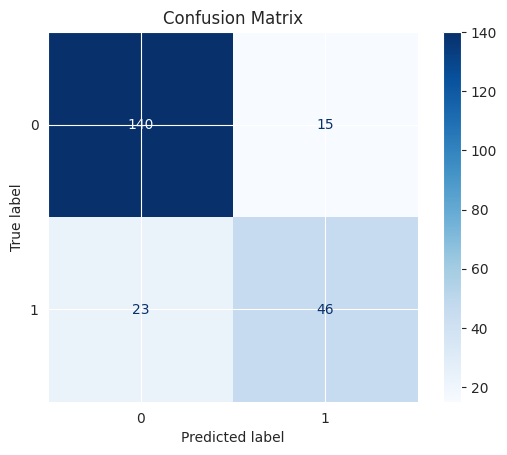

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


## Feature Reduction/Elimination
We can reduce the dimension of features, but we get reduced performance.

In [12]:
"""Recursive Feature Elimination"""

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Initialize logistic regression model for RFE
model = LogisticRegression()

# Initialize RFE with the logistic regression model
rfe = RFE(estimator=model, n_features_to_select=3)

# Fit RFE
rfe = rfe.fit(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[rfe.support_]
print("Selected Features:", selected_features)

# Reduce the dataset to selected features
X_train_rfe = X_train[selected_features]
X_test_rfe = X_test[selected_features]

# Train Random Forest model with reduced features
rf_model_rfe = RandomForestClassifier(random_state=42)
rf_model_rfe.fit(X_train_rfe, y_train)

# Evaluate the reduced model
y_pred_rfe = rf_model_rfe.predict(X_test_rfe)
print(classification_report(y_test, y_pred_rfe))

Selected Features: Index(['1_week_roc', 'week_of_year', 'moving_avg_WIS'], dtype='object')
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       155
           1       0.69      0.64      0.66        69

    accuracy                           0.80       224
   macro avg       0.77      0.75      0.76       224
weighted avg       0.80      0.80      0.80       224

